In [1]:
import pandas as pd
from xgboost import XGBClassifier 
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from pprint import pprint
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, roc_auc_score, ConfusionMatrixDisplay
from scipy.stats import uniform, randint
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
df = pd.read_csv('fake_job_postings.csv')

In [3]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
top_three_df= df[["job_id", "description", "requirements", "company_profile", "fraudulent"]]

In [5]:
top_three_df.dropna(inplace = True)

/tmp/ipykernel_9039/1097173744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_three_df.dropna(inplace = True)


In [6]:
print(len(top_three_df[top_three_df['description'].apply(len)<9]))
print(len(top_three_df[top_three_df['requirements'].apply(len)<9]))
print(len(top_three_df[top_three_df['company_profile'].apply(len)<9]))

3
42
0


In [7]:
df_description = df[["job_id", "description", "fraudulent"]]

In [8]:
df_description

,job_id,description,fraudulent
0,1,"Food52, a fast-growing, James Beard Award-winn...",0
1,2,Organised - Focused - Vibrant - Awesome!Do you...,0
2,3,"Our client, located in Houston, is actively se...",0
3,4,THE COMPANY: ESRI – Environmental Systems Rese...,0
4,5,JOB TITLE: Itemization Review ManagerLOCATION:...,0
...,...,...,...
17875,17876,Just in case this is the first time you’ve vis...,0
17876,17877,The Payroll Accountant will focus primarily on...,0
17877,17878,Experienced Project Cost Control Staff Enginee...,0
17878,17879,Nemsia Studios is looking for an experienced v...,0


In [9]:
df_description.isna().sum()
df_description.dropna(inplace=True)

/tmp/ipykernel_9039/481444835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_description.dropna(inplace=True)


<BarContainer object of 2 artists>

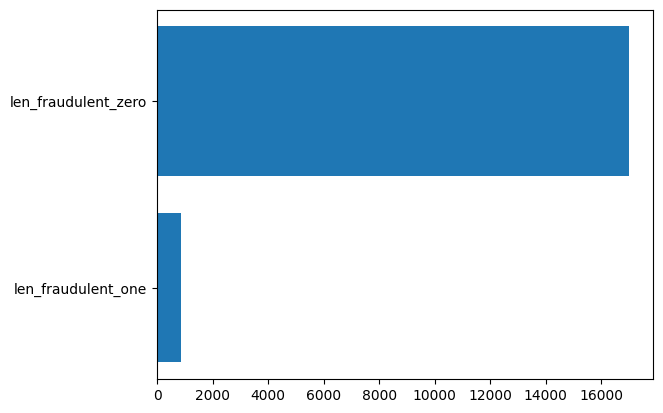

In [10]:
len_fraudulent_one = df_description[df_description["fraudulent"]==1]
len_fraudulent_zero = df_description[df_description["fraudulent"]==0]
plt.barh(["len_fraudulent_one", "len_fraudulent_zero"], [len(len_fraudulent_one), len(len_fraudulent_zero)])

data is  `imbalance`

In [11]:
description_train = df_description["description"].values.tolist()
description_test = df_description["fraudulent"]
X_train, X_test, y_train, y_test = train_test_split(description_train, description_test, test_size=0.3, random_state=42)

`TfidfVectorizer` = `CountVectorizer` -> `TfidfTransformer`

In [12]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
X_train_tfidf_vect = vectorizer.fit_transform(X_train)
X_test_tfidf_vect = vectorizer.transform(X_test)

In [23]:
vect_count = CountVectorizer()
vect_feature = vect_count.fit_transform(X_train)

2


In [13]:
pos_weight = sum(y_train==0)/sum(y_train==1)
pos_weight

19.68595041322314

In [14]:
param_distributions = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.05, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'subsample': uniform(0.6, 0.4),
    'n_estimators': randint(100, 1000),
    'reg_alpha': uniform(0.0, 1.0),
    'reg_lambda': uniform(0.0, 1.0),
    'scale_pos_weight': uniform(0.0, 1.0),
}
model = XGBClassifier(scale_pos_weight=pos_weight)
RSCV = RandomizedSearchCV(model, param_distributions, n_iter= 20, scoring= 'roc_auc', cv =10)

RSCV.fit(X_train_tfidf_vect, y_train)

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ffb03e78b50>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ffb03e79240>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ffb03e7a320>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ffb03e78f40>},
                   scoring='roc_auc')

In [15]:
print(RSCV.best_score_)
print(RSCV.best_params_)

0.9421085853372055
{'colsample_bytree': 0.7166569409405297, 'learning_rate': 0.19987004118068918, 'max_depth': 3, 'n_estimators': 517, 'reg_alpha': 0.017078010399950716, 'reg_lambda': 0.966841112476633, 'scale_pos_weight': 0.9773238669420389, 'subsample': 0.8388308312965698}


In [16]:
pred =RSCV.predict(X_test_tfidf_vect)
print(roc_auc_score(y_test, pred))

0.8152504822763443


In [17]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5104
           1       0.89      0.63      0.74       260

    accuracy                           0.98      5364
   macro avg       0.93      0.82      0.86      5364
weighted avg       0.98      0.98      0.98      5364



<AxesSubplot: >

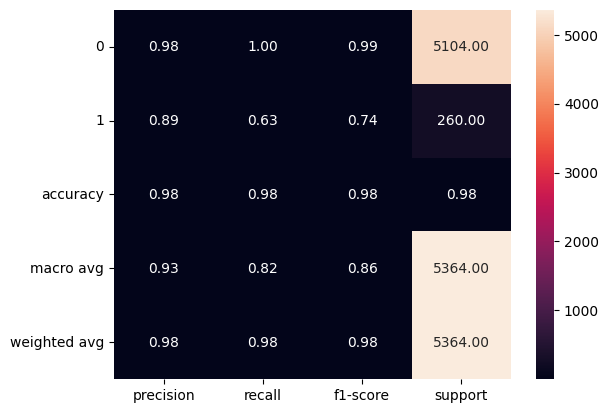

In [18]:
sns.heatmap(pd. DataFrame(classification_report(y_test, pred, output_dict = True)).T, annot = True, fmt=".2f")

[[5083   21]
 [  95  165]]


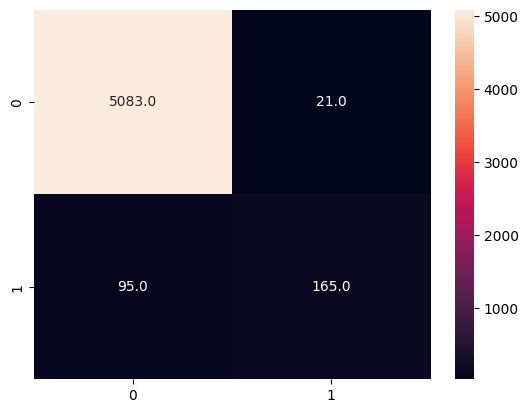

In [19]:
sns.heatmap(confusion_matrix(y_test, pred),  annot=True, fmt=".1f")
print(confusion_matrix(y_test, pred))
plt.show()